In [47]:
using GLMakie
using Oceananigans
using Oceananigans.Units
using Oceananigans.TurbulenceClosures: CATKEVerticalDiffusivity

Ut = FieldTimeSeries("langmuir_turbulence_averages.jld2", "u")
Vt = FieldTimeSeries("langmuir_turbulence_averages.jld2", "v")
Bt = FieldTimeSeries("langmuir_turbulence_averages.jld2", "b")

les_grid = Ut.grid
grid = RectilinearGrid(size=size(les_grid, 3), z=(-les_grid.Lz, 0), topology=(Flat, Flat, Bounded))
closure = CATKEVerticalDiffusivity()

f = 1e-4
coriolis = FPlane(; f)

τˣ = -1e-4
Jᵇ = 1e-7

x_wind_stress = FluxBoundaryCondition(τˣ)
cooling = FluxBoundaryCondition(Jᵇ)
u_bcs = FieldBoundaryConditions(top=x_wind_stress)
b_bcs = FieldBoundaryConditions(top=cooling)

model = HydrostaticFreeSurfaceModel(; grid, closure, coriolis,
                                    tracers = (:b, :e),
                                    buoyancy = BuoyancyTracer(),
                                    boundary_conditions = (; u=u_bcs, b=b_bcs))

set!(model, b=Bt[1])

simulation = Simulation(model, Δt=5minutes, stop_time=Bt.times[end])

outputs = merge(model.velocities, model.tracers)
output_interval = Bt.times[2] - Bt.times[1]

output_writer = JLD2OutputWriter(model, outputs,
                                 schedule = TimeInterval(output_interval),
                                 filename = "catke_turbulence_fields.jld2",
                                 overwrite_existing = true)


simulation.output_writers[:jld2] = output_writer

run!(simulation)

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (4.359 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (1.192 ms).
[ Info: Simulation is stopping after running for 40.195 ms.
[ Info: Simulation time 1 hour equals or exceeds stop time 1 hour.


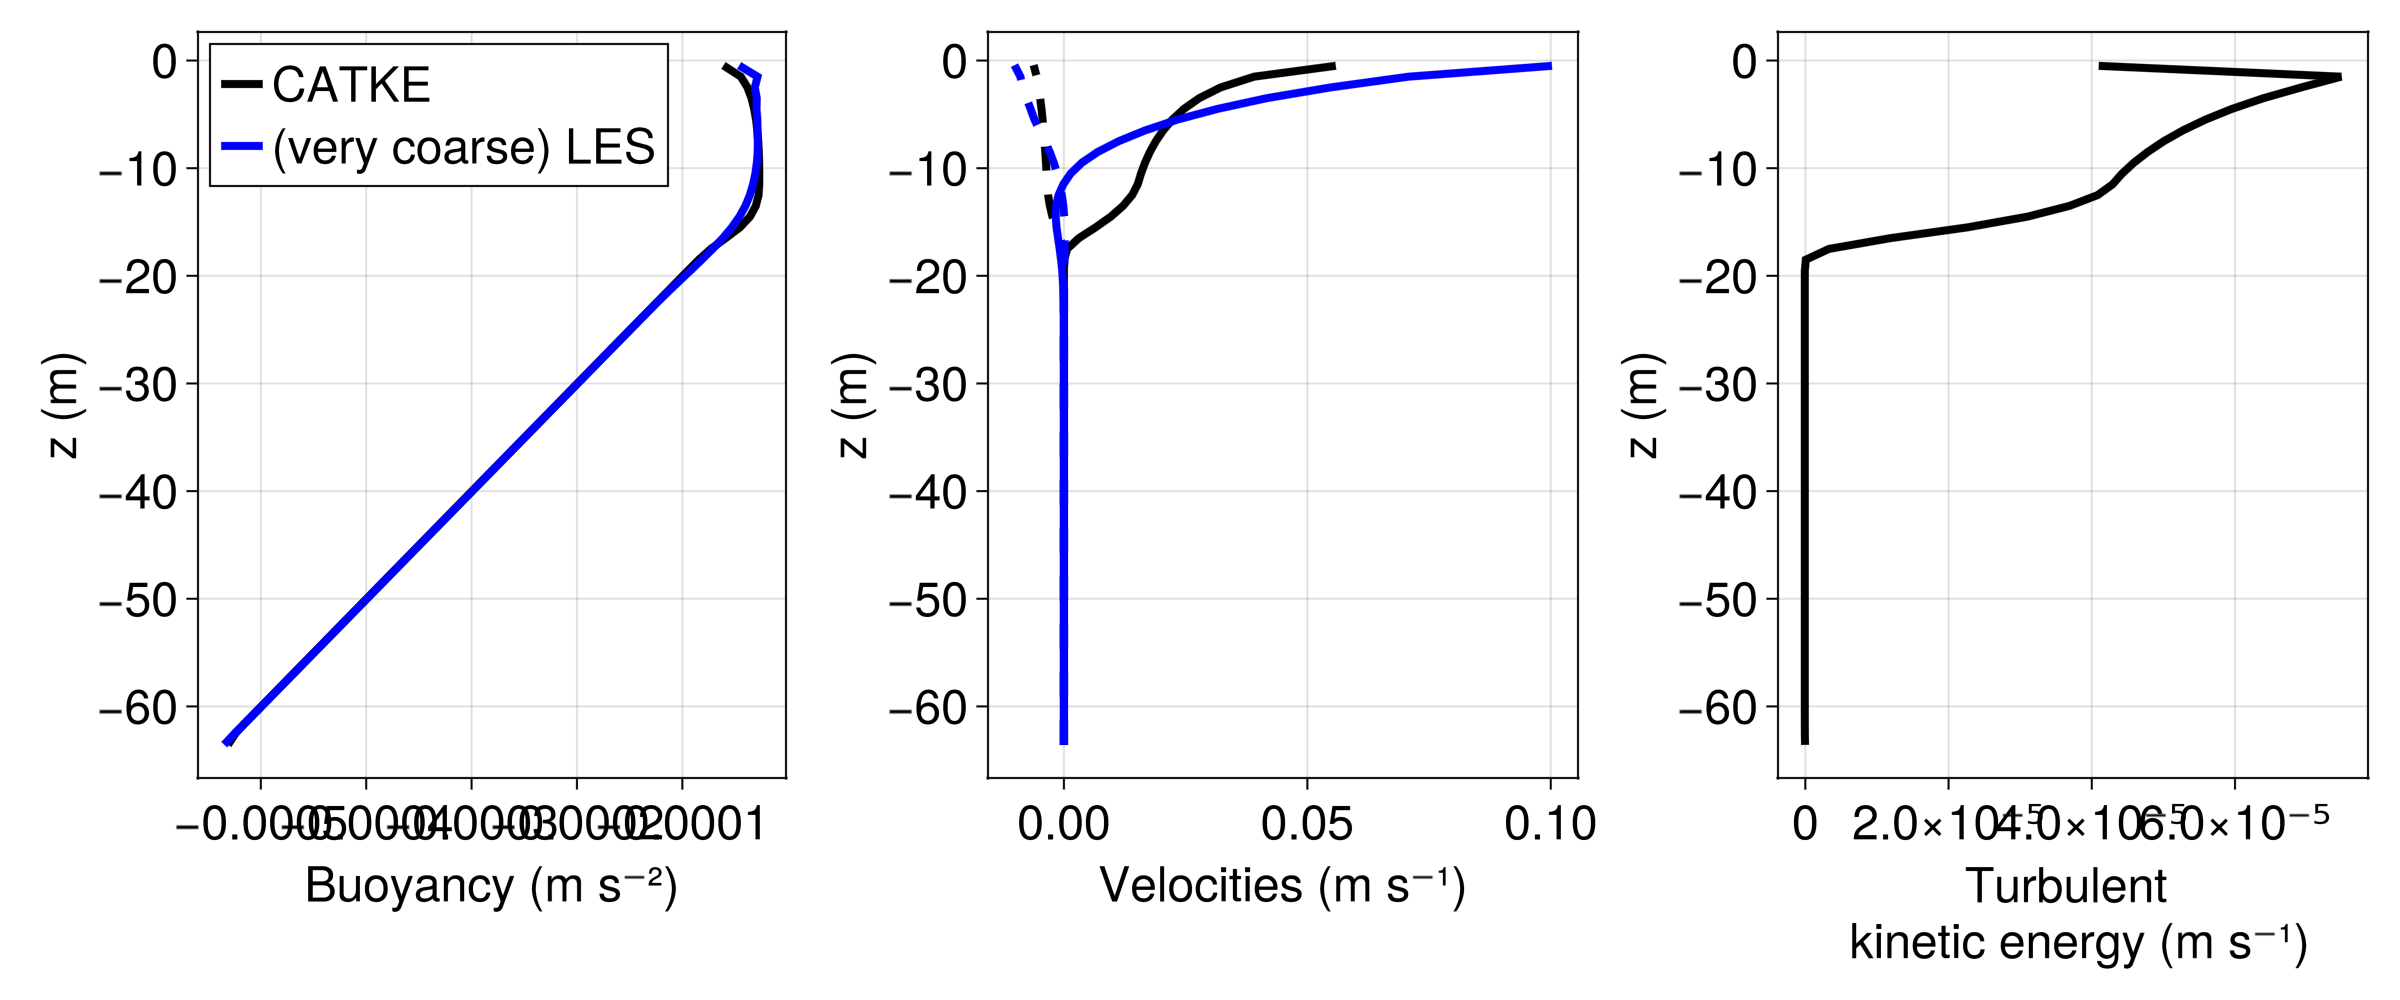

In [46]:
Bt_CATKE = FieldTimeSeries("catke_turbulence_fields.jld2", "b")
Ut_CATKE = FieldTimeSeries("catke_turbulence_fields.jld2", "u")
Vt_CATKE = FieldTimeSeries("catke_turbulence_fields.jld2", "v")
et_CATKE = FieldTimeSeries("catke_turbulence_fields.jld2", "e")

set_theme!(Theme(linewidth=4, fontsize=24))

fig = Figure(size=(1200, 500))

axb  = Axis(fig[1, 1], xlabel="Buoyancy (m s⁻²)", ylabel="z (m)")
axu  = Axis(fig[1, 2], xlabel="Velocities (m s⁻¹)", ylabel="z (m)")
axe  = Axis(fig[1, 3], xlabel="Turbulent \n kinetic energy (m s⁻¹)", ylabel="z (m)")

n = Nt
Un = interior(Ut[n], 1, 1, :)
Vn = interior(Vt[n], 1, 1, :)
Bn = interior(Bt[n], 1, 1, :)

Un_CATKE = interior(Ut_CATKE[n], 1, 1, :)
Vn_CATKE = interior(Vt_CATKE[n], 1, 1, :)
Bn_CATKE = interior(Bt_CATKE[n], 1, 1, :)
en_CATKE = interior(et_CATKE[n], 1, 1, :)

lines!(axb, Bn_CATKE, zb, color=:black, label="CATKE")
lines!(axu, Un_CATKE, zb, color=:black)
lines!(axu, Vn_CATKE, zb, color=:black, linestyle=:dash)

lines!(axb, Bn, zb, color=:blue, label="(very coarse) LES")
lines!(axu, Un, zb, color=:blue)
lines!(axu, Vn, zb, color=:blue, linestyle=:dash)

lines!(axe, en_CATKE, zb, color=:black)

axislegend(axb, position=:lt)

fig